In [114]:
#!//usr/bin/python3.6

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import preprocessing

separator = '=' * 30

idToData = {}


def loadTrainLabels(path):
    pairs = np.loadtxt(path, delimiter=',', skiprows=1, dtype=int)
    return pairs[:, 0], pairs[:, 1]

def sortData():
    idsOfUser = np.zeros((21, 450), dtype=int)
    for u in range(1, 21):
        idsOfUser[u, :] = allTrainId[ allTrainLabel == u ]

    return idsOfUser

count = 0
def loadData(path, ids, user):
    global count
    npArraysOfUser = []
    
    for id in ids:
        count += 1
        arr = np.loadtxt(path + str(id) + ".csv", delimiter=',', skiprows=0, dtype=np.float64)
        npArraysOfUser.append(arr)

        ##################################
        if (count % 1000 == 0):
            print("loaded", count, "data")
            print(separator, "\n")
    
    print("loaded data for user", user)
    return npArraysOfUser

            

def interpolateData(sample):
    newSample = np.zeros((150, 3))

    x = np.arange(1, 150 + 1, 1)
    xp = np.linspace(1, 150, sample.shape[0])
    for k in range(0, 3):
        yp = sample[:, k]
        newSample[:, k] = np.interp(x, xp, yp)

    return newSample
            
            
def getShapedData(ids):
    arrays = []
    for id in ids:
        data = idToData[id]
        
        ##################################################
        data = np.ravel(data, order='C')
        
        arrays.append(data)
    
    ret = np.stack(arrays, axis=0)
    return ret
    



In [53]:







allTrainId, allTrainLabel = loadTrainLabels("../../data/train_labels.csv")
idsOfUser = sortData()

# print("ids of the first user:", idsOfUser[1, :], end="\n")
# print("num of ids of the first user:", idsOfUser[1, :].size, end="\n")


dataOfUser = [0] * 21
for u in range(1, 20 + 1):
    dataOfUser[u] = loadData(path="../../data/train/", ids=idsOfUser[u, :], user=u)
print("done with loading")
print(separator)

    

for u in range(1, 20 + 1):
    for s in range(0, 450):
        dataOfUser[u][s] = interpolateData(dataOfUser[u][s])
        
        if dataOfUser[u][s].size != 450:
            raise Exception('spam', 'eggs')
print("done with interpolating")
print(separator)

print("done")


loaded data for user 1
loaded data for user 2
loaded 1000 data

loaded data for user 3
loaded data for user 4
loaded 2000 data

loaded data for user 5
loaded data for user 6
loaded 3000 data

loaded data for user 7
loaded data for user 8
loaded 4000 data

loaded data for user 9
loaded data for user 10
loaded data for user 11
loaded 5000 data

loaded data for user 12
loaded data for user 13
loaded 6000 data

loaded data for user 14
loaded data for user 15
loaded 7000 data

loaded data for user 16
loaded data for user 17
loaded 8000 data

loaded data for user 18
loaded data for user 19
loaded 9000 data

loaded data for user 20
done with loading
done with interpolating
done


In [126]:
# for extracting features

# windowExtract functions:
def getMin(sample):
    ans = []
    
    for k in range(3):
        ans.append(sample[:, k].min())
    
    return np.array(ans)


def getMax(sample):
    ans = []
    
    for k in range(3):
        ans.append(sample[:, k].max())
    
    return np.array(ans)

def getNumPeaks(sample):
    ans = []
    
    for k in range(3):
        coords = sample[:, k]
        
        curr = 0
        for i in range(1, coords.size - 1):
            if coords[i-1] < coords[i] and coords[i] > coords[i + 1]:
                curr += 1
            elif coords[i-1] > coords[i] and coords[i] < coords[i + 1]:
                curr += 1
        
        ans.append(curr)
        
    return np.array(ans)

def getAverages(sample):
    ans = []
    
    for k in range(3):
        ans.append(sample[:, k].mean())
    
    return np.array(ans)
    
def getAverageDifferences(sample):
    diffs = np.zeros( (sample.shape[0] - 1, sample.shape[1]) )
    
    for i in range(len(sample) - 1):
        diffs[i, :] = sample[i+1, :] - sample[i, :]
    
    return diffs.mean(axis = 0)

def getWindowExtractFunctions():
    ans = []
    
    ans.append(getMin)
    ans.append(getMax)
    ans.append(getNumPeaks)
    ans.append(getAverages)
    ans.append(getAverageDifferences)
    
    return ans
windowExtract = getWindowExtractFunctions()
numWindows = 3

def getWindows(sample, indexes = np.split( np.arange(0, 150), numWindows),  ):
    for windowIndexes in indexes:
        subSample = sample[windowIndexes, :]
        yield subSample


        
# wholeExtract functions:

# return the variance of the number of peaks in each window
def getPeaksVariance(sample):
    nums = []
    for subSample in getWindows(sample):
        nums.append(getNumPeaks(subSample))
    nums = np.array(nums)

    ans = []
    for k in range(3):
        ans.append( nums[:, k].var() )
    
    return np.array(ans)

    
    
def getWholeExtractFunctions():
    ans = []
    
    ans.append(getPeaksVariance)
    
    return ans
wholeExtract = getWholeExtractFunctions()





def extractFeatures(sample):
    acumulator = []
    
    for subSample in getWindows(sample):
        for f in windowExtract:
            acumulator.append(f(subSample))
    
    for f in wholeExtract:
        acumulator.append(f(sample))
    
    result = np.concatenate(tuple(acumulator), axis=None)
    return result


sampleFeatureList = []
for u in range(1, 20 + 1):
    for s in range(450):
        sample = dataOfUser[u][s]
        
        features = extractFeatures(sample)
        sampleFeatureList.append(features)


structuredFeatures = np.stack(sampleFeatureList, axis=0)

print("finished extracting features")
print("structuredFeatures.shape =", structuredFeatures.shape)
# print(structuredFeatures[:5, :])
print(separator)



finished extracting features
structuredFeatures.shape = (9000, 48)


In [127]:
# scaling functions

scaler = None
def fitScaler(structuredData):
    global scaler
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaler.fit(structuredData)

def normalizeData(structuredData):
    return scaler.transform(structuredData)

In [128]:
numberOfBuckets = 10

def getDataSplits(structuredData, numSplits):
    userSplitted = np.split(np.arange(9000), 20)
    
    indexes = []
    for user in userSplitted:
        dataSplitted = np.split(user, numSplits)
        curr = []
        for data in dataSplitted:
            curr.append(data)
        
        indexes.append(curr)

    indexes = np.array(indexes, dtype=int)
    
    dataBuckets = np.zeros((numSplits, 9000 // numSplits), dtype=int)
    for i in range(numSplits):
        dataBuckets[i, :] = indexes[:, i, :].ravel()
    
    for alone in range(numSplits):
        validationIndexes = dataBuckets[alone, :]
        
        if alone == 0:
            trainIndexes = dataBuckets[1:, :].ravel()
        elif alone == numSplits - 1:
            trainIndexes = dataBuckets[:-1, :].ravel()
        else:
            trainIndexes = np.r_[dataBuckets[:alone, :].ravel(), dataBuckets[(alone+1):, :].ravel()]
            
        trainData = structuredData[trainIndexes, :]
        trainLabels = np.array( [idx // 450 + 1 for idx in trainIndexes] )
        
        validationData = structuredData[validationIndexes, :]
        validationLabels = np.array( [idx // 450 + 1 for idx in validationIndexes] )
        
        yield trainData, trainLabels, validationData, validationLabels
        

def doValidationRBF(C, gamma, trainData, trainLabels, validationData, validationLabels):
    svm_model = svm.SVC(C=C, kernel='rbf', gamma=gamma)
    svm_model.fit(trainData, trainLabels)
    predictedLabels = svm_model.predict(validationData)

    # print(predictedLabels); print(separator)

    accuracy = (predictedLabels == validationLabels).sum() / validationLabels.size
    print("accuracy of validation = ", accuracy)
    print("C = %s, kernel = %s, gamma = %s" % (C, "rbf", gamma))
    return accuracy

Cs = [1.0, 10.0, 100.0]
accuracies = np.zeros((len(Cs), numberOfBuckets))
j = 0
for trainData, trainLabels, validationData, validationLabels in getDataSplits(structuredFeatures, numberOfBuckets):
#     print("trainData.shape =", trainData.shape)
#     print("trainLabels.shape =", trainLabels.shape)
#     print("validationData.shape =", validationData.shape)
#     print("validationLabels.shape =", validationLabels.shape)
#     print(separator)

    fitScaler(trainData)
    trainData = normalizeData(trainData)
    validationData = normalizeData(validationData)
    
    for i in range(len(Cs)):
        C = Cs[i]
        
        accuracies[i, j] = doValidationRBF(C, 'scale', trainData, trainLabels, validationData, validationLabels)
    
    j += 1    

print("len(validationLabels) =", len(validationLabels))
# print(list(validationLabels))


print("done with crossvalidation for")

for i in range(len(Cs)):
    C = Cs[i]
    acc = accuracies[i, :].mean()
    print("mean accuracy from cross-validation for C = %.4f is %.4f%%" % (C, acc * 100))
    
print("done with crossvalidation")
print(separator)

accuracy of validation =  0.9211111111111111
C = 1.0, kernel = rbf, gamma = scale
accuracy of validation =  0.9477777777777778
C = 10.0, kernel = rbf, gamma = scale
accuracy of validation =  0.9455555555555556
C = 100.0, kernel = rbf, gamma = scale
accuracy of validation =  0.9022222222222223
C = 1.0, kernel = rbf, gamma = scale
accuracy of validation =  0.9366666666666666
C = 10.0, kernel = rbf, gamma = scale
accuracy of validation =  0.9444444444444444
C = 100.0, kernel = rbf, gamma = scale
accuracy of validation =  0.9077777777777778
C = 1.0, kernel = rbf, gamma = scale
accuracy of validation =  0.9544444444444444
C = 10.0, kernel = rbf, gamma = scale
accuracy of validation =  0.9522222222222222
C = 100.0, kernel = rbf, gamma = scale
accuracy of validation =  0.9077777777777778
C = 1.0, kernel = rbf, gamma = scale
accuracy of validation =  0.9555555555555556
C = 10.0, kernel = rbf, gamma = scale
accuracy of validation =  0.9577777777777777
C = 100.0, kernel = rbf, gamma = scale
accu

In [129]:
# cell for getting output





mask = np.ones(24000 + 1, dtype=bool)
mask[allTrainId] = False
mask = mask[10001 : 24000 + 1]
testId = np.arange(10001, 24000 + 1)[mask]


testData = loadData(path="../../data/test/", ids=testId, user='test')
print("loaded test data")
print(separator)

for i in range(len(testData)):
    testData[i] = interpolateData(testData[i])
print("interpolated test data")
print(separator)



loaded 11000 data

loaded 12000 data

loaded 13000 data

loaded 14000 data

loaded 15000 data

loaded data for user test
loaded test data
interpolated test data


In [130]:
testFeatures = []
for sample in testData:
    features = extractFeatures(sample)
    testFeatures.append(features)
testFeatures = np.stack(testFeatures, axis=0)

print(testFeatures.shape)
print(structuredFeatures.shape)


fitScaler(structuredFeatures)
structuredFeatures = normalizeData(structuredFeatures)
testFeatures = normalizeData(testFeatures)

trainLabels = [idx // 450 + 1 for idx in range(0,9000)]

svm_model = svm.SVC(C=100.0, kernel='rbf', gamma='scale')
svm_model.fit(structuredFeatures, trainLabels)
predictedLabels = svm_model.predict(testFeatures)


print("predicted the labels as:")
print(predictedLabels)

np.savetxt("result.csv", np.stack((testId, predictedLabels)).T, fmt="%s", delimiter=',', header="id,class", comments='')
print("done with writing")




(5000, 48)
(9000, 48)
predicted the labels as:
[ 3  4  5 ... 11  5  1]
done with writing


iterating over sample:


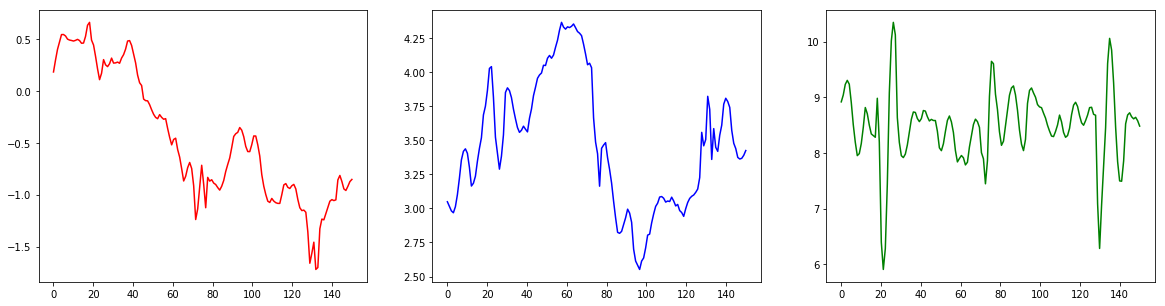

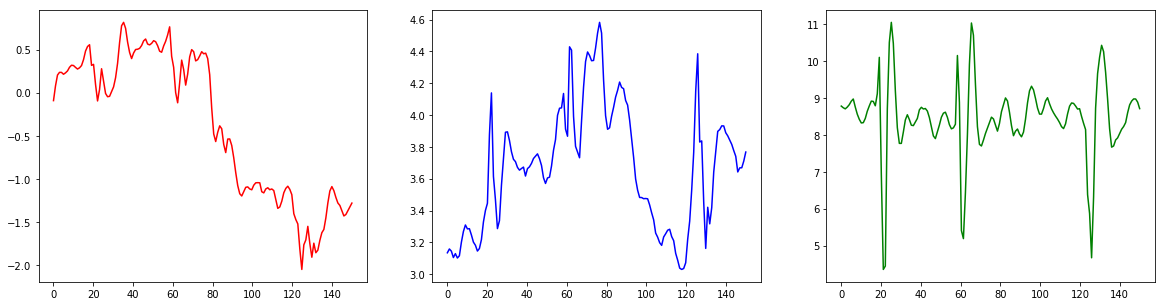

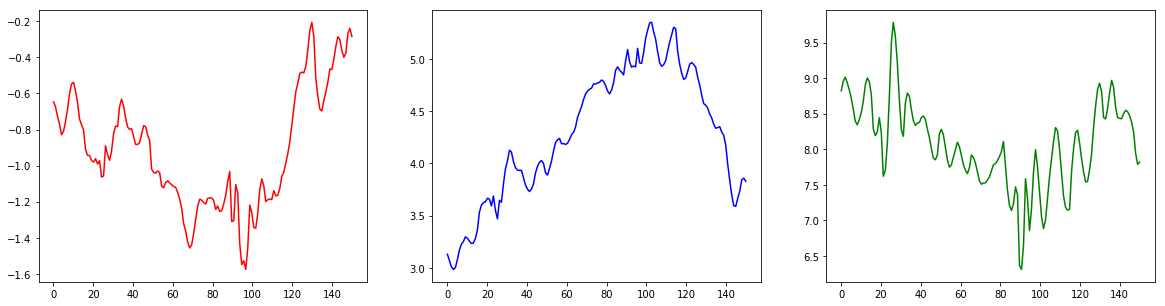

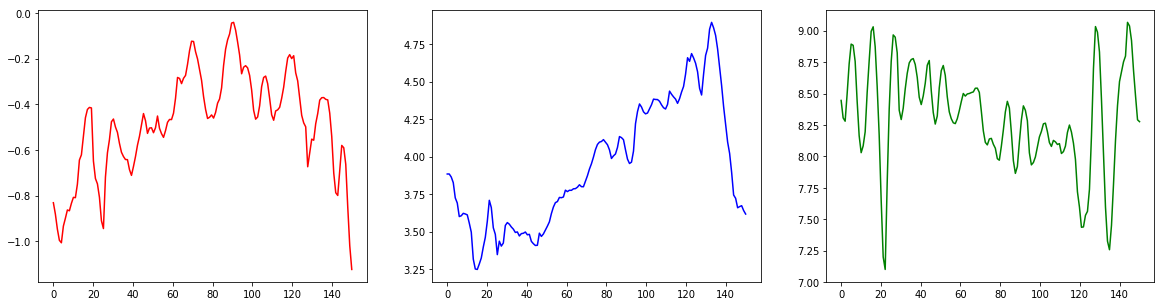

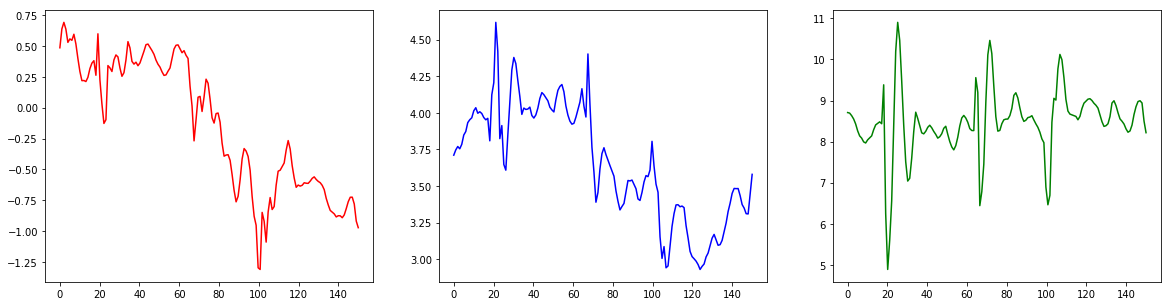

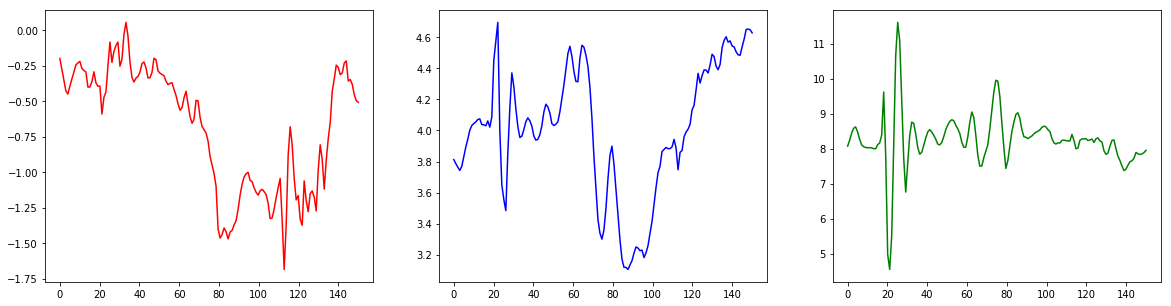

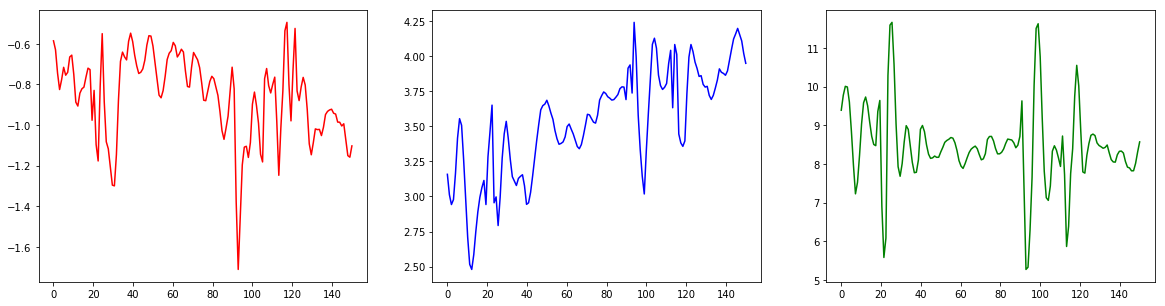

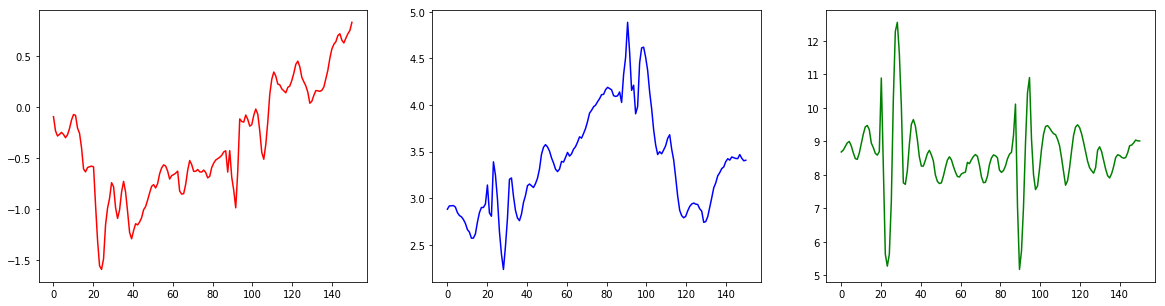

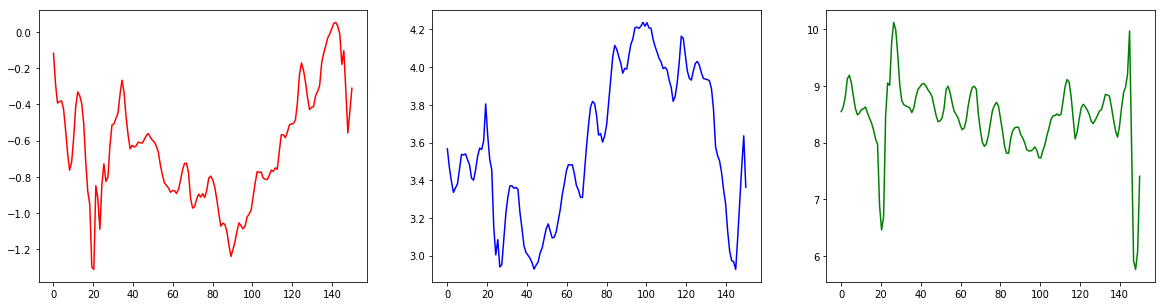

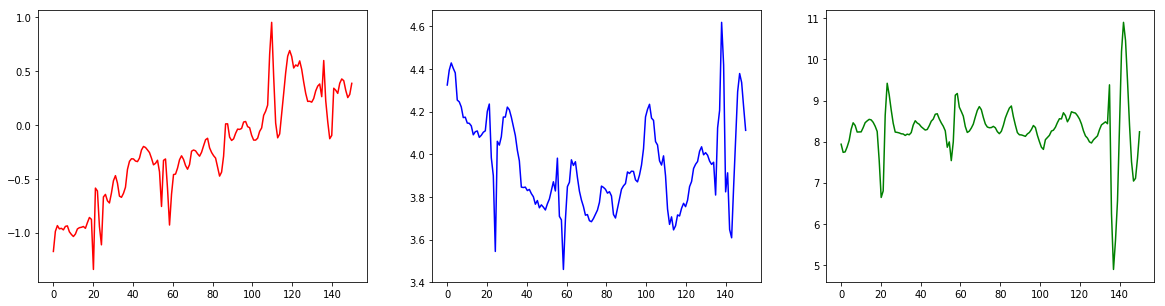

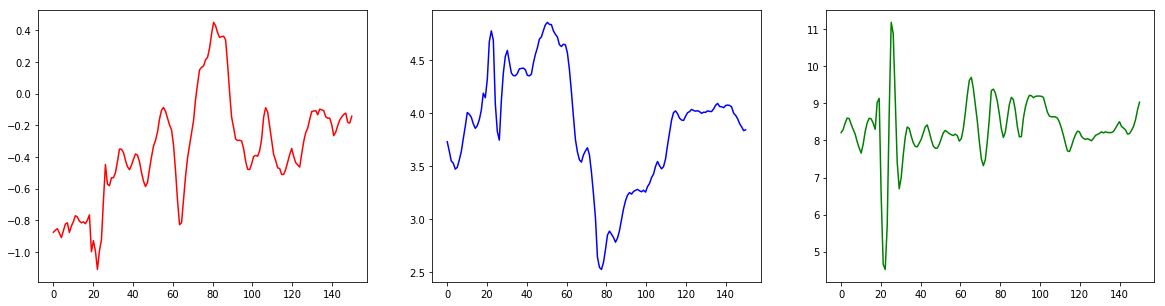

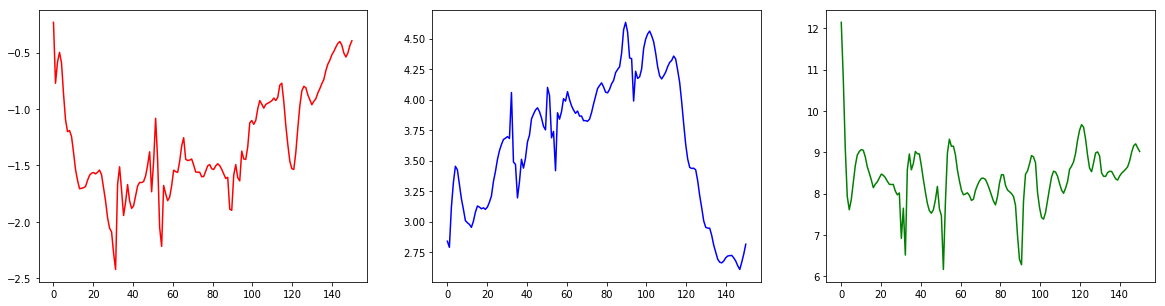

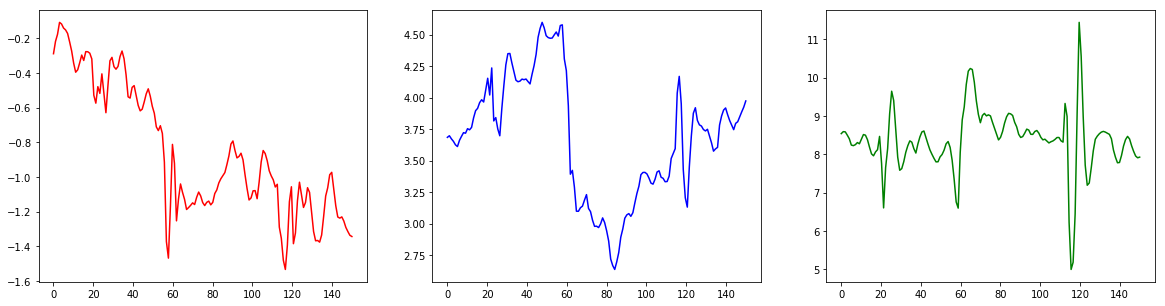

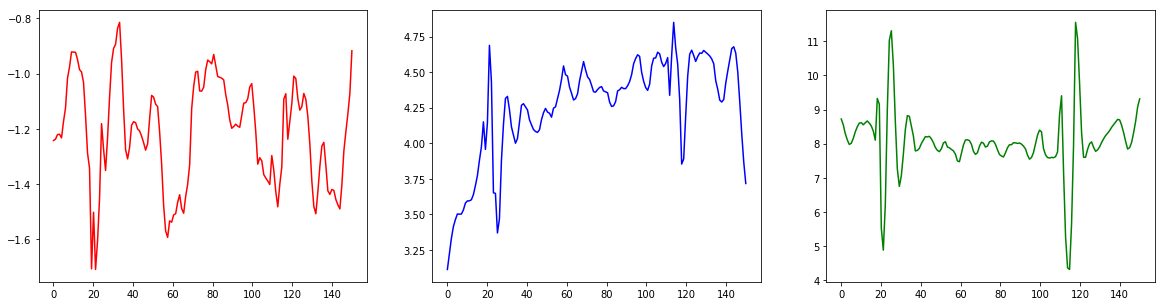

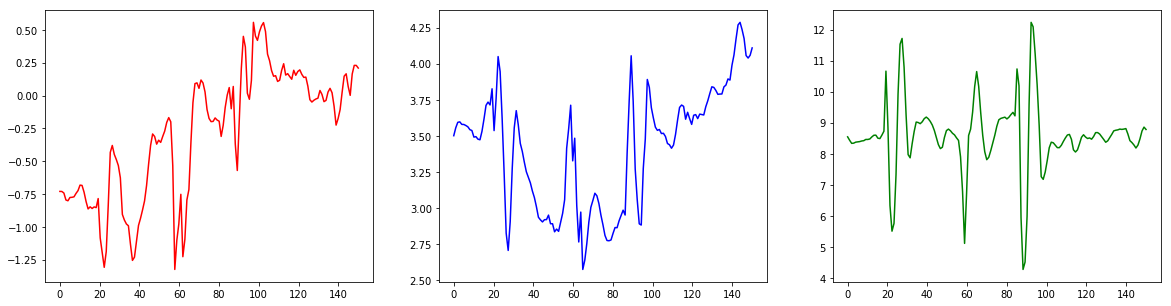

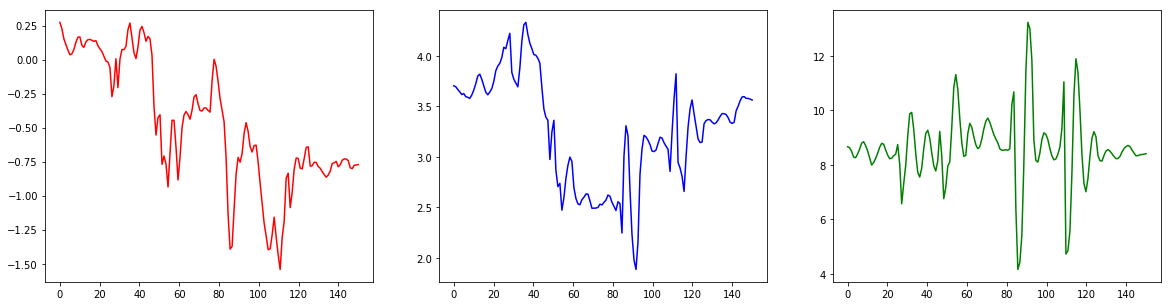

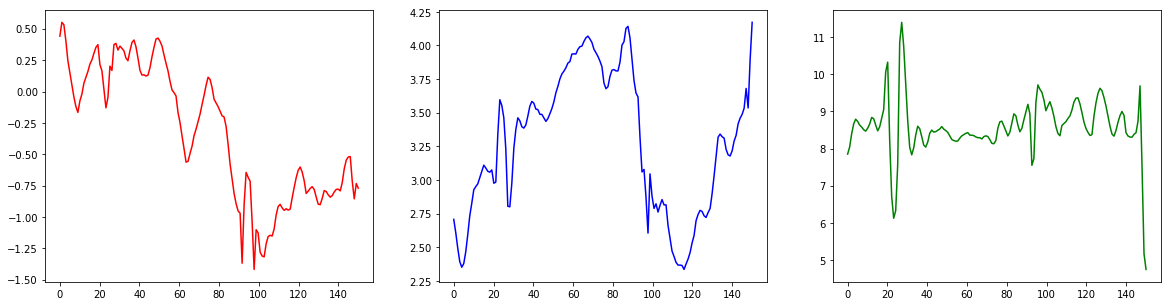

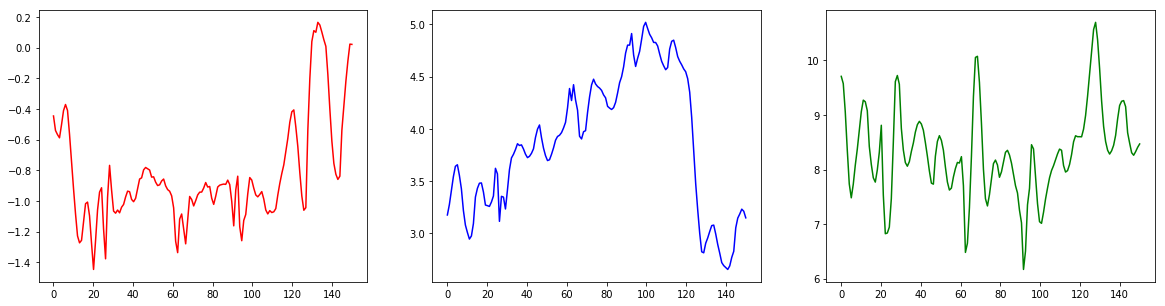

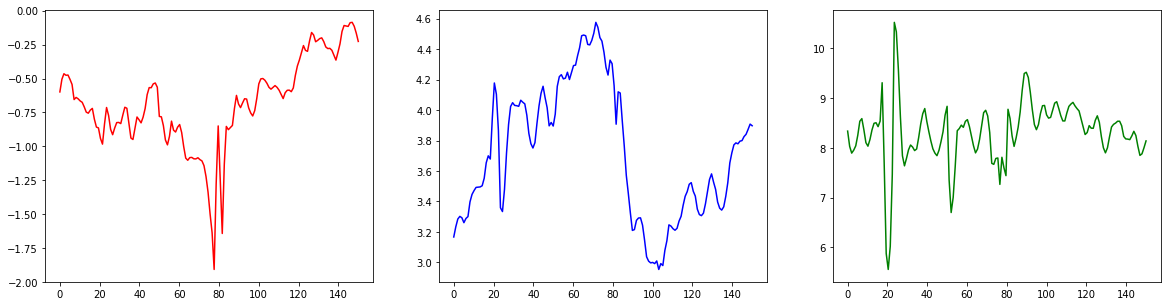

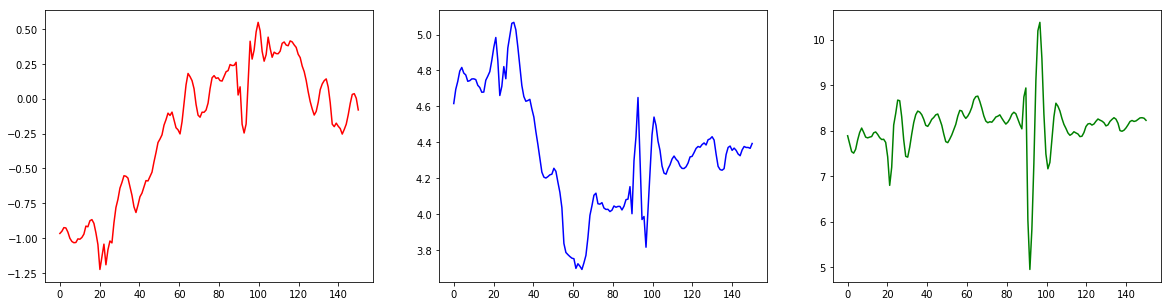

In [49]:
# for testing plotting

# plt.plot([1,2,3,4], 'ro')
# plt.ylabel("i greci")
# plt.axis([-1, 4, 0, 5])
# plt.show()



# user = 1
# plt.figure(figsize=(20,5))
# plt.subplot(1, 3, 1)
# for i in range(0, 450, 90):
#     data = dataOfUser[user][i][:, 0]
#     x = np.linspace(0, 150, data.size)
#     plt.plot(x, data)
    
# #     print(data.size)
# #     print(x.size)
# #     print("plotted the %ith plot" % i)


# print("iterating over user:")
# sample = 0
# for user in range(1, 20 + 1):
#     plt.figure(figsize=(20, 5))
    
#     for k in range(0, 3):
#         plt.subplot(1, 3, k + 1)
#         data = dataOfUser[user][sample][:, k]
#         x = np.linspace(0, 150, data.size)
#         plt.plot(x, data)
    
#     plt.show()
# print(separator)

print("iterating over sample:")
user = 1
for sample in range(0, 20):
    plt.figure(figsize=(20, 5))
    
    k = 0
    plt.subplot(1, 3, k + 1)
    data = dataOfUser[user][sample][:, k]
    x = np.linspace(0, 150, data.size)
    plt.plot(x, data, 'r')
    
    k = 1
    plt.subplot(1, 3, k + 1)
    data = dataOfUser[user][sample][:, k]
    x = np.linspace(0, 150, data.size)
    plt.plot(x, data, 'b')
    
    k = 2
    plt.subplot(1, 3, k + 1)
    data = dataOfUser[user][sample][:, k]
    x = np.linspace(0, 150, data.size)
    plt.plot(x, data, 'g')
    
    plt.show()
print(separator)


In [110]:
# for testing stuff

import numpy as np

a = np.arange(1,5)
print(a % 2 == 0)

b = np.arange(1,5)
print(b[ np.array([True, True, False, False]) ])

print(np.linspace(1, 10, 5))

print(~np.array([True, False, True, False, False, False]))

[False  True False  True]
[1 2]
[ 1.    3.25  5.5   7.75 10.  ]
[False  True False  True  True  True]


In [120]:
def add(x, y):
    return x + y

def sub(x, y):
    return x - y

funcs = [add, sub]
for f in funcs:
    print(f(2,4))
    

arr = np.array([
    [5, 6, 7],
    [7, 8, 9],
    [9, 7, 100]
])

print(arr.mean(axis = 0))

6
-2
[ 7.          7.         38.66666667]
